In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import copy
import cv2
import matplotlib.pyplot as plt
import numpy as np
import toml
import glob
import joblib
import h5py
from tqdm.auto import tqdm
from qd_analysis.fig import setup_plotting_env

In [3]:
from joblib import Parallel, delayed
import pandas as pd
import seaborn as sns

In [4]:
from markovids import vid, pcl

In [5]:
config = toml.load("../preprocessing/config.toml")

In [6]:
fig_dir = config["dirs"]["figs"]
os.makedirs(fig_dir, exist_ok=True)

In [7]:
npcols = ["ave_corr", "ave_raw_corr", "intrinsic_matrix", "distortion_coeffs"] 

In [8]:
base_colors = sns.color_palette("deep", n_colors=7)
palette = {"qd_vascular_labels": base_colors[0],
           "qd_cell_labels": base_colors[1],
           "qd_beads": base_colors[2],
           "qd_beads_v2": base_colors[3],
           "qd_conj_fibro_click_v2": base_colors[4],
           "qd_conj_coll_click_v2": base_colors[5],
           "qd_cell_labels_v2": base_colors[6]}

# Load in data

In [9]:
corr_df = pd.read_parquet(
    os.path.join(config["dirs"]["data"], "dataframes/fluorescence_autocorrelation.parquet")
)
corr_df.loc[corr_df["subject"].str.contains("qdr_exp"), "exp_type"] = "exposure"

In [10]:
filenames = corr_df["filename"].unique()
metadata = {}
save_metadata = {"gain": {}, "pulse_width": {}}
for _filename in tqdm(filenames):
    metadata[_filename] = toml.load(os.path.join(os.path.dirname(_filename), "../metadata.toml")) 
    cameras = list(metadata[_filename]["cameras"].keys())
    save_metadata["gain"][_filename] = np.round(metadata[_filename]["camera_metadata"][cameras[0]]["Gain"])
    save_metadata["pulse_width"][_filename] = metadata[_filename]["cli_parameters"]["hw_trigger_pulse_width"][1]
corr_df["gain"] = corr_df["filename"].map(save_metadata["gain"])
corr_df["pulse_width"] = corr_df["filename"].map(save_metadata["pulse_width"])

  0%|          | 0/1470 [00:00<?, ?it/s]

In [11]:
exclude_subjects = ["qd_beads_01","qd_beads_02","qd_beads_03"] # pilot experiments
corr_df = corr_df.query("~subject.isin(@exclude_subjects)")

In [12]:
for _col in npcols:
    corr_df[_col] = corr_df[_col].apply(np.vstack)

In [13]:
im_width, im_height = corr_df["ave_corr"].iat[0].shape

In [14]:
max_lag = im_width // 2
lags = np.arange(-max_lag, max_lag)

In [15]:
xx, yy = np.meshgrid(np.arange(im_width), np.arange(im_height))

In [16]:
ave_matrix = np.stack(list(corr_df["intrinsic_matrix"])).mean(axis=0)
# this is really just for viz and sanity checks

In [17]:
px = ave_matrix[0,2]
py = ave_matrix[1,2]
fx = ave_matrix[0,0]
fy = ave_matrix[1,1]

In [18]:
z = 304.8 # distance to middle in mm(approximate), corresponds to 12 inches
parameters = {}
xhat = z * (xx - px) / fx
yhat = z * (yy - py) / fy
ymm_per_px = np.diff(yhat,axis=0).mean()
xmm_per_px = np.diff(xhat,axis=1).mean()
    # coords[k] = (xx - v["px"])

In [19]:
use_mm_per_px = np.mean([xmm_per_px, ymm_per_px])

In [20]:
xs = np.arange(-max_lag, max_lag) * use_mm_per_px
ys = np.arange(-max_lag, max_lag) * use_mm_per_px

In [21]:
tqdm.pandas()

In [22]:
crop = slice(im_width // 2 - 30, im_width // 2 + 30)

In [23]:
fits = corr_df["ave_raw_corr"].progress_apply(lambda x: pcl.fluo.fit_2d_gaussian_with_moments(x[crop,crop])[0])
fits = fits.apply(pd.Series)

  0%|          | 0/1370 [00:00<?, ?it/s]

In [24]:
fits.columns = [f"fit_{_}" for _ in fits.columns]

In [25]:
try:
    corr_df = corr_df.join(fits)
except ValueError:
    corr_df = corr_df.drop(fits.columns, axis=1)
    corr_df = corr_df.join(fits)

# Spatial autocorrelation on day 0

In [26]:
use_corr_df = corr_df.query("days==0")

In [27]:
setup_plotting_env()

In [28]:
max_display = 5.

In [29]:
im_params = {"cmap": "cubehelix", "vmin": 0, "vmax": 1}
ax_params = {"xticks": np.arange(-5., 5.1, 2.5), "yticks": np.arange(-5., 5.1, 2.5),
             "xlim": (-max_display, max_display), "ylim": (-max_display, max_display)}

In [30]:
show_categories = [
    "qd_vascular_labels",
    "qd_cell_labels",
    "qd_beads", 
]

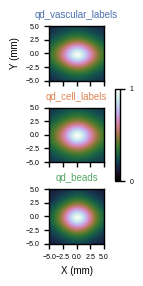

In [31]:
fig, ax = plt.subplots(
    len(show_categories),
    1,
    figsize=(1, 1 * len(show_categories)),
    sharex=True,
    sharey=True,
)
for _category, _ax in zip(show_categories, ax):
    _ave = np.stack(
        use_corr_df.query(f"days == 0 & exp_type == '{_category}'")["ave_corr"].to_list()
    ).mean(axis=0)
    h = _ax.imshow(
        _ave,
        **im_params,
        extent=[
            -max_lag * use_mm_per_px,
            max_lag * use_mm_per_px,
            -max_lag * use_mm_per_px,
            max_lag * use_mm_per_px,
        ],
    )
    _ax.set_title(_category, color=palette[_category])
ax[0].set_ylabel("Y (mm)")
ax[-1].set_xlabel("X (mm)")
ax[0].set(**ax_params)
fig.colorbar(h, ax=ax, shrink=.4, pad=.15, ticks=[0,1])
fig.show()
fig.savefig(os.path.join(fig_dir, f"qd_spatial_autocorr_{show_categories}.pdf"), dpi=600, bbox_inches="tight")

# Look at diffusion...

In [32]:
plt_df = corr_df.groupby(["exp_type", "subject", "camera", "days"])[["fit_amplitude","fit_sigma_x", "fit_sigma_y"]].mean().reset_index()

In [33]:
threshold = 0

In [34]:
plt_df = plt_df.query("fit_amplitude > @threshold")

In [35]:
palette = { "qd_cell_labels_v2": sns.color_palette("bright")[1],
            "qd_beads_v2": sns.color_palette("bright")[2],
            "qd_conj_coll_click_v2": sns.color_palette("bright")[3],
            "qd_conj_fibro_click_v2": sns.color_palette("bright")[4]}

In [36]:
setup_plotting_env()

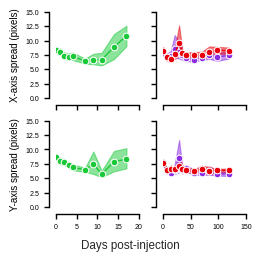

In [37]:
fig, ax = plt.subplots(2, 2, figsize=(2.5,2.5), sharex="col", sharey=True, layout="constrained")
sns.lineplot(
    plt_df,
    x="days",
    y="fit_sigma_x",
    hue="exp_type",
    palette=palette,
    hue_order=[
        # "qd_beads_v2",
        # "qd_cell_labels_v2",
        "qd_conj_fibro_click_v2",
        "qd_conj_coll_click_v2",
    ],
    err_kws={"alpha": .5},
    marker="o",
    legend=False,
    ax=ax[0][1],
)
sns.lineplot(
    plt_df,
    x="days",
    y="fit_sigma_y",
    hue="exp_type",
    palette=palette,
    hue_order=[
        # "qd_beads_v2",
        # "qd_cell_labels_v2",
        "qd_conj_fibro_click_v2",
        "qd_conj_coll_click_v2",
    ],
    err_kws={"alpha": .5},
    legend=False,
    marker="o",
    ax=ax[1][1],
)

sns.lineplot(
    plt_df,
    x="days",
    y="fit_sigma_x",
    hue="exp_type",
    palette=palette,
    hue_order=[
        "qd_beads_v2",
        # "qd_cell_labels_v2",
    ],
    err_kws={"alpha": .5},
    marker="o",
    legend=False,
    ax=ax[0][0],
)
sns.lineplot(
    plt_df,
    x="days",
    y="fit_sigma_y",
    hue="exp_type",
    palette=palette,
    hue_order=[
        "qd_beads_v2",
        # "qd_cell_labels_v2",
    ],
    err_kws={"alpha": .5},
    legend=False,
    marker="o",
    ax=ax[1][0],
)

ax[0][1].set_ylim(0,15)
ax[0][1].set_xlim(0,150)
ax[1][0].set_xlim(0,20)
ax[1][0].set_xlabel("")
ax[1][1].set_xlabel("")
fig.supxlabel("Days post-injection")
# ax[1].set_xticks([0, 130])
# ax[1].legend(bbox_to_anchor=(1.05,1.))
ax[0][0].set_ylabel("X-axis spread (pixels)")
ax[1][0].set_ylabel("Y-axis spread (pixels)")
# ax[1].set_xlabel("Days post-injection")
sns.despine(trim=True, offset=5)
fig.savefig(os.path.join(fig_dir, "autocorr_xyspread_antibodies&beadsv2.pdf"), bbox_inches="tight", dpi=600)

# Have a look at spatial autocorrelation for the dilution series...

In [38]:
def get_center_value(x, radius=10):
    h, w = x.shape
    use_mask = np.zeros(x.shape, dtype="bool")
    h, w = x.shape
    cy, cx = h // 2, w // 2
    Y, X = np.ogrid[:h, :w]
    r = np.sqrt((Y - cy)**2 + (X - cx)**2)
    use_mask[r < radius] = 1
    peak_power = x[use_mask].mean()
    return peak_power

In [39]:
def get_border_amplitude(x, radius=(10,100)):
    use_mask = np.zeros(x.shape, dtype="bool")
    h, w = x.shape
    cy, cx = h // 2, w // 2
    Y, X = np.ogrid[:h, :w]
    r = np.sqrt((Y - cy)**2 + (X - cx)**2)
    use_mask[(r > radius[0]) & (r<radius[1])] = 1
    noise_power = x[use_mask].mean()
    return noise_power

In [40]:
cell_label_df = corr_df.query("subject.str.contains('cell') and days == 0 and exp_type != 'exposure' and pulse_width == .023").copy()

In [41]:
cell_label_df["volume"] = cell_label_df["subject"].str.extract("(\.*\d+)ul").astype("float")
cell_label_df["volume"] = cell_label_df["volume"].fillna(2)

In [42]:
cell_label_df["corr_peak"] = cell_label_df["ave_corr"].apply(get_center_value)
cell_label_df["corr_std"] = cell_label_df["ave_corr"].apply(get_border_amplitude)
cell_label_df["corr_snr"] = ((cell_label_df["corr_peak"] - cell_label_df["corr_std"]))

In [43]:
ave_cell_label_df = cell_label_df.groupby(["subject", "camera", "volume"])[
    ["corr_peak", "corr_snr", "corr_std", "fit_amplitude", "fit_sigma_x", "fit_sigma_y"]
].mean()

In [44]:
ave_cell_label_df["fit_ratio"] = (
    ave_cell_label_df["fit_sigma_x"] / ave_cell_label_df["fit_sigma_y"]
)

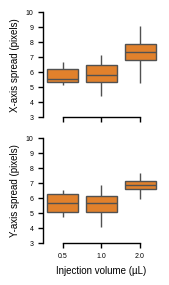

In [45]:
fig, ax = plt.subplots(2, 1, figsize=(1.5,3), sharex=True, sharey=True)
sns.boxplot(
    data=ave_cell_label_df,
    x="volume",
    y="fit_sigma_x",
    showfliers=False,
    showcaps=False,
    color="tab:orange",
    ax=ax[0],
)
sns.boxplot(
    data=ave_cell_label_df,
    x="volume",
    y="fit_sigma_y",
    showfliers=False,
    color="tab:orange",
    showcaps=False,
    ax=ax[1],
)
ax[1].set_ylim(3,10)
ax[1].set_xlabel("Injection volume (µL)")
ax[0].set_ylabel("X-axis spread (pixels)")
ax[1].set_ylabel("Y-axis spread (pixels)")
sns.despine(trim=True)
fig.savefig(os.path.join(fig_dir, "autocorr_xyspread_dilution_cell_labels.pdf"), bbox_inches="tight", dpi=600)

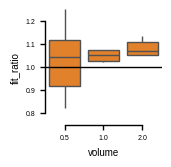

In [46]:
fig, ax = plt.subplots(1, figsize=(1.5,1.5))
sns.boxplot(
    data=ave_cell_label_df,
    x="volume",
    y="fit_ratio",
    color="tab:orange",
    showfliers=False,
    showcaps=False,
)
ax.axhline(y=1, color="k")
ax.set_ylim(.75, 1.25)
sns.despine(trim=True)
fig.savefig(os.path.join(fig_dir, "autocorr_spread_x-to-y-ratio_dilution_cell_labels.pdf"), bbox_inches="tight", dpi=600)

# Load in fluorescence amplitudes to get some SNR measurements...

In [47]:
fluo_df = pd.read_parquet(    
    os.path.join(config["dirs"]["data"], "dataframes/fluorescence_intensity_over_time.parquet")
)
fluo_df.loc[fluo_df["subject"].str.contains("qdr_exp"),"exp_type"] = "exposure"

In [48]:
filenames = fluo_df["filename"].unique()
metadata = {}
save_metadata = {"gain": {}}
for _filename in tqdm(filenames):
    try:
        metadata[_filename] = toml.load(os.path.join(os.path.dirname(_filename), "../metadata.toml")) 
    except FileNotFoundError:
        continue
    cameras = list(metadata[_filename]["cameras"].keys())
    save_metadata["gain"][_filename] = np.round(metadata[_filename]["camera_metadata"][cameras[0]]["Gain"])
fluo_df["gain"] = fluo_df["filename"].map(save_metadata["gain"])

  0%|          | 0/1470 [00:00<?, ?it/s]

In [49]:
fluo_df["pulse_width"] = fluo_df["hw_trigger_pulse_width"].apply(lambda x: float(x.split(", ")[1][:-1]))

In [50]:
fluo_df["volume"] = fluo_df["subject"].str.extract("(\.*\d+)ul").astype("float")
fluo_df["volume"] = fluo_df["volume"].fillna(2)
use_fluo_df = fluo_df.query("subject.str.contains('cell') and days == 0 and exp_type != 'exposure' and pulse_width == .023").copy()

In [51]:
plt_var = "q1.0_fullframe_bpass"

In [52]:
plt_data = (
    use_fluo_df.groupby(["days", "subject", "camera", "exp_type", "pulse_width", "volume"])[plt_var]
    .mean()
).reset_index()

In [53]:
blank_ci = fluo_df.query("exp_type == 'vehicle_v2'").groupby(["subject","filename"])[plt_var].mean()
rng = np.random.default_rng(seed=0)
rand_mus = [blank_ci.sample(frac=1, replace=True, random_state=rng).mean() for _ in range(1000)]
rand_mus = pd.DataFrame(rand_mus)
ci_high = rand_mus.quantile(.99)

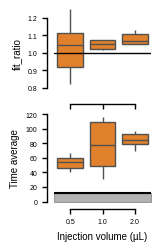

In [54]:
fig, ax = plt.subplots(2, 1, figsize=(1.25,2.5), sharex=True)

sns.boxplot(
    data=ave_cell_label_df,
    x="volume",
    y="fit_ratio",
    color="tab:orange",
    showfliers=False,
    showcaps=False,
    ax=ax[0],
)
ax[0].axhline(y=1, color="k")
ax[0].set_ylim(.75, 1.25)
# sns.despine(trim=True)

sns.boxplot(
    plt_data,
    showcaps=False,
    showfliers=False,
    color="tab:orange",
    x="volume",
    y="q1.0_fullframe_bpass",
    ax=ax[1],
)
xlims = ax[1].get_xlim()
ax[1].fill_between(x=xlims, y1=[ci_high.iat[0]]*2, color="k", alpha=.3)
ax[1].axhline(y=ci_high.iat[0], color="k", lw=1.5)
ax[1].set_xlim(xlims)
ax[1].set_ylim(0,120)
ax[1].set_ylabel("Time average")
ax[1].set_xlabel("Injection volume (µL)")
sns.despine(offset=5, trim=True)
fig.savefig(os.path.join(fig_dir, "average_aspect_ratio_and_fluorescence_dilution_cell_labels.pdf"), bbox_inches="tight", dpi=600)

In [55]:
use_fluo_df = fluo_df.query("subject.str.contains('cell') and days == 0 and exp_type == 'exposure'").copy()

In [56]:
plt_data = (
    use_fluo_df.groupby(["days", "subject", "camera", "exp_type", "pulse_width", "gain", "volume"])[plt_var]
    .mean()
).reset_index()

In [57]:
exposure_df = corr_df.query("days == 0 and exp_type == 'exposure'").copy()
exposure_df["im_size"] = exposure_df["im_shape"].apply(np.prod)
exposure_df["corr_peak"] = exposure_df["ave_corr"].apply(get_center_value)
exposure_df["corr_std"] = exposure_df["ave_corr"].apply(get_border_amplitude)
exposure_df["corr_snr"] = ((exposure_df["corr_peak"] - exposure_df["corr_std"]))
ave_corr_df = exposure_df.groupby(["exp_type","pulse_width","gain","filename"])[["corr_snr","fit_sigma_x","fit_sigma_y"]].mean().reset_index()

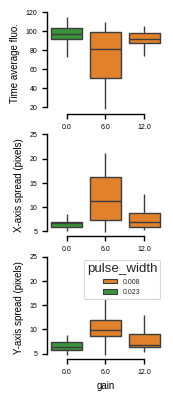

In [58]:
fig, ax = plt.subplots(3,1, figsize=(1.5,4.5))
sns.boxplot(
    plt_data,
    showfliers=False,
    showcaps=False,
    hue="pulse_width",
    palette=sns.color_palette("tab10")[1:3],
    x="gain",
    y="q1.0_fullframe_bpass",
    ax=ax[0],
    legend=False,
)
sns.boxplot(
    data=ave_corr_df,
    x="gain",
    y="fit_sigma_x",
    showfliers=False,
    showcaps=False,
    hue="pulse_width",
    palette=sns.color_palette("tab10")[1:3],
    ax=ax[1],
    legend=False,
)
sns.boxplot(
    data=ave_corr_df,
    x="gain",
    y="fit_sigma_y",
    showfliers=False,
    showcaps=False,
    hue="pulse_width",
    palette=sns.color_palette("tab10")[1:3],
    ax=ax[2],
)
ax[1].set_ylim(4,25)
ax[2].set_ylim(4,25)
# ax[1].set_xlabel("Gain (dB)")
ax[0].set_ylabel("Time average fluo.")
ax[1].set_ylabel("X-axis spread (pixels)")
ax[2].set_ylabel("Y-axis spread (pixels)")

sns.despine(trim=True)
fig.savefig(os.path.join(fig_dir, "autocorr_xyspread_gain.pdf"), bbox_inches="tight", dpi=600)